In [1]:
# Version info: R 3.2.3, Biobase 2.30.0, GEOquery 2.40.0, limma 3.26.8
################################################################
#   Differential expression analysis with limma
library(GEOquery)
library(limma)
library(edgeR)
library(gt) 
library(DT) 
library(plotly) 
library(tidyverse)
library(ggplot2)
library(ggrepel)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)


Attaching package: ‘limma’


The following obj

In [25]:
# load series and platform data from GEO

gset <- getGEO("GSE13205", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL570", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

Found 1 file(s)

GSE13205_series_matrix.txt.gz

File stored at: 

/var/folders/63/kvjwtxbn1hqfmqdmm3m1gg0r0000gn/T//Rtmp85YgF1/GPL570.annot.gz



In [26]:
# group membership for all samples
gsms <- "000000000000011111111"
sml <- strsplit(gsms, split="")[[1]]

# log2 transformation
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }

In [5]:
# assign samples to groups and set up design matrix
gs <- factor(sml)
groups <- make.names(c("Sepsis","Control"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

fit <- lmFit(gset, design)  # fit linear model

In [6]:
# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)

tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","t","B","logFC","Gene.symbol","Gene.title"))
write.table(tT, file=stdout(), row.names=F, sep="\t")

"ID"	"adj.P.Val"	"P.Value"	"t"	"B"	"logFC"	"Gene.symbol"	"Gene.title"
"203021_at"	1.19988545758683e-11	3.38167368690275e-16	21.2797189333572	24.8435681139497	5.81349575769231	"SLPI"	"secretory leukocyte peptidase inhibitor"
"209276_s_at"	1.1166059600926e-09	6.29392909132854e-14	16.5532382964042	20.8151184014265	3.24645674519231	"GLRX"	"glutaredoxin"
"201310_s_at"	3.91715857393125e-08	3.55130760061585e-12	-13.5522858251686	17.4068338481754	-3.88973725192307	"NREP"	"neuronal regeneration related protein"
"206662_at"	3.91715857393125e-08	4.41593886920834e-12	13.4037639396563	17.216492143668	3.76256611057693	"GLRX"	"glutaredoxin"
"206461_x_at"	4.82829213134723e-07	7.52476158788723e-11	11.583413461895	14.6903820342813	3.590797875	"MT1H"	"metallothionein 1H"
"215223_s_at"	4.82829213134723e-07	9.46087818123689e-11	11.4449972294686	14.4827283269587	3.82594534134616	"LOC100129518///SOD2"	"uncharacterized LOC100129518///superoxide dismutase 2, mitochondrial"
"222139_at"	4.82829213134723e-07	9.52

In [11]:
write.csv(ex, "/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/humanmusclernaseq_individualvalues.csv")

In [11]:
# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

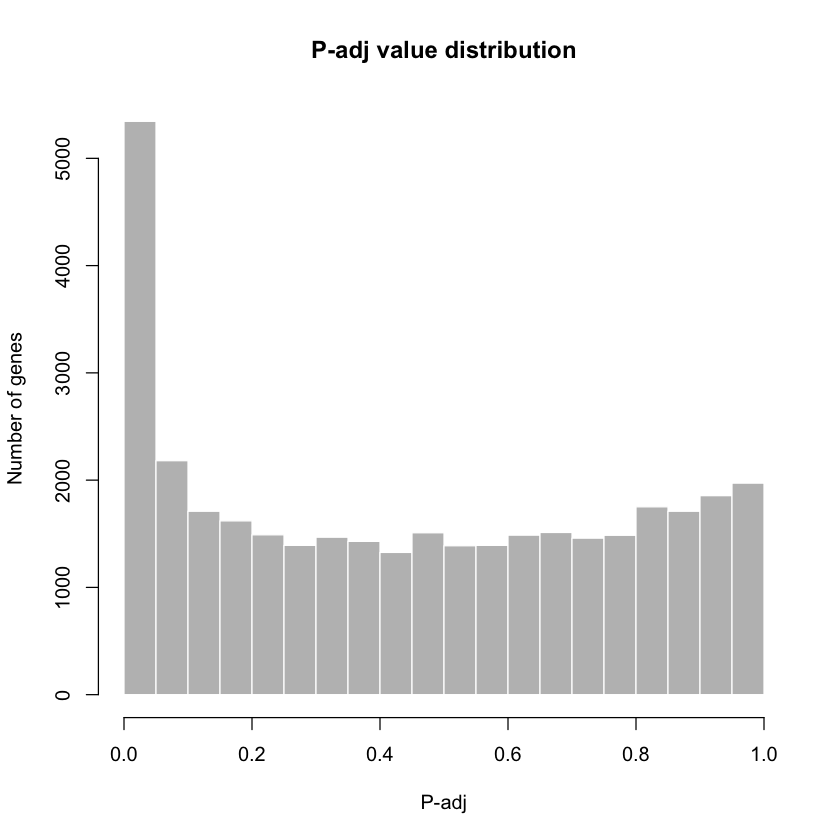

In [22]:
# Visualize and quality control test results.
# Build histogram of P-values for all genes. Normal test
# assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution")

In [23]:
# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05)

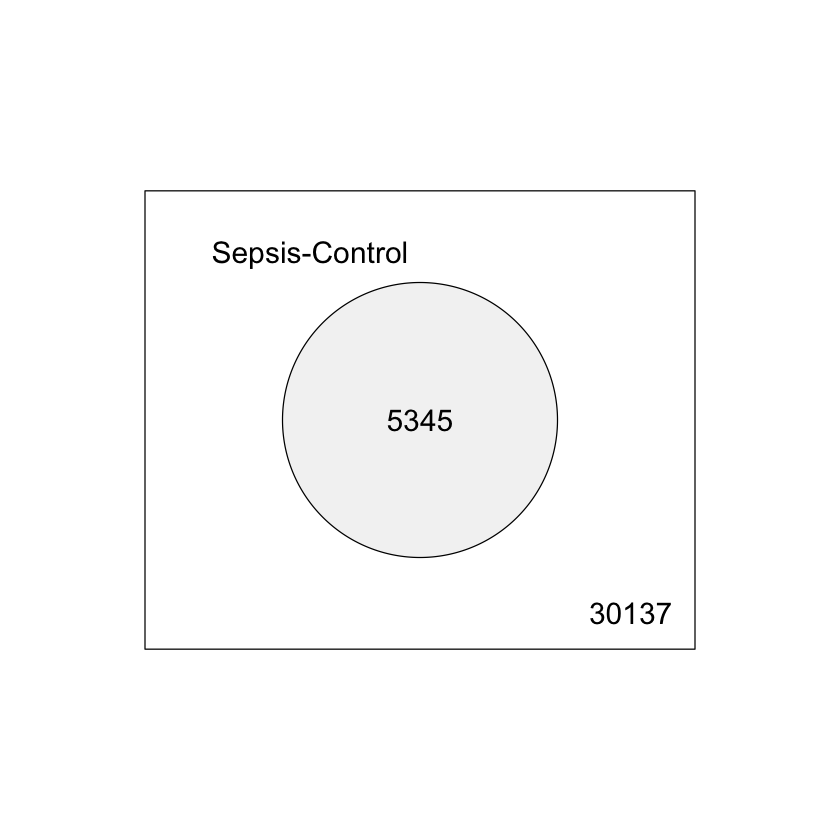

In [24]:
# Venn diagram of results
vennDiagram(dT, circle.col=palette())

[1] "Sepsis-Control"

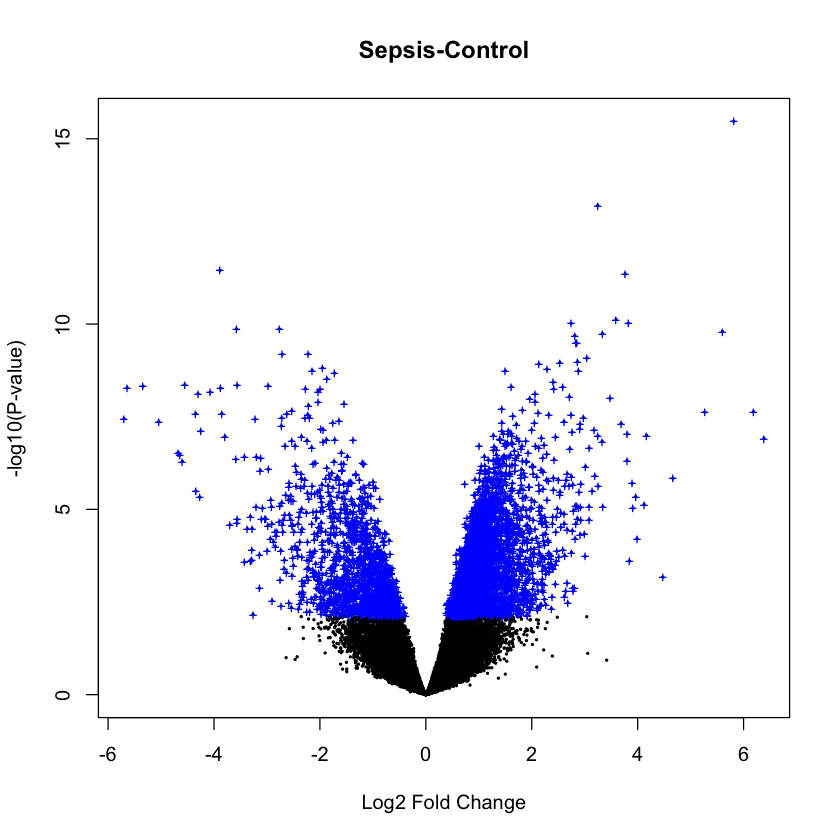

In [26]:
# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
  highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

In [28]:
write.csv(tT2, "/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/humanmusclernaseq.csv")

# PCA Plot

In [18]:
muscleRNA_df_raw1  <- read.csv('/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/musclerna_forPCA.csv')

muscleRNA_df_raw = subset(muscleRNA_df_raw1, select = -X)
#rename rownames

muscle_rna_df <- muscleRNA_df_raw[,-1]
rownames(muscle_rna_df) <- muscleRNA_df_raw[,1]

#Make dataframe a matrix for PCA

muscle_rna_matrix <- data.matrix(muscle_rna_df, rownames.force = TRUE)

In [19]:
muscle_rna_matrix

,GSM333436,GSM333437,GSM333438,GSM333439,GSM333440,GSM333441,GSM333442,GSM333443,GSM333444,GSM333445,⋯,GSM333447,GSM333448,GSM333449,GSM333450,GSM333451,GSM333452,GSM333453,GSM333454,GSM333455,GSM333456
SLPI,11.3848910,10.648463,10.923185,13.0953750,11.5629930,11.5020220,12.445532000,11.308302,11.7841015,11.8222870,⋯,10.8963850,11.8440810,4.920381,5.470458,5.4699163,6.147131,5.568495,6.393591,5.9894850,6.460956
GLRX,12.0914510,11.895017,11.279280,12.4752140,11.9881140,12.5021120,12.280694000,11.874362,11.9218570,10.8153240,⋯,11.7762440,12.4169410,8.815347,8.565437,8.8779850,9.162516,8.695642,8.600282,8.3513110,8.647517
NREP,6.1443176,7.485987,6.854233,5.1610170,6.5223045,5.2784640,6.162810300,6.199494,4.7927470,5.3739643,⋯,5.7739325,6.5155697,9.609034,10.152899,10.4092270,9.497991,10.380123,10.214155,9.8445580,9.308896
MT1H,12.9619030,11.906353,10.723534,13.1074120,12.3019700,12.9436330,12.693871000,12.783438,12.5893840,12.1968580,⋯,12.5545330,11.8838390,8.038809,9.767063,8.2719750,10.025666,9.059821,8.012578,8.2806600,9.238365
ERV3-2,8.6643510,7.357189,7.104464,7.7993293,8.2401905,7.4865360,7.580537000,7.174735,7.4356213,7.0755020,⋯,8.0010660,7.2188540,4.651606,5.340128,4.6977210,4.554833,5.242632,5.500862,4.9396553,4.700130
AQP4,4.7018723,4.385984,5.314309,3.9594352,4.0235786,3.4770284,3.718430800,3.547026,3.6086210,3.6270761,⋯,4.1431320,3.7080348,6.740407,6.359926,7.5031910,6.310933,7.326321,7.401066,6.3136760,6.745846
LSMEM1,4.0123500,5.535854,4.731952,4.2448240,4.5518740,3.6161945,3.960677600,5.250728,3.6922648,2.4301740,⋯,4.8298736,4.9100800,7.964346,7.634995,8.1930020,7.884925,8.646431,7.962567,6.7521840,8.184529
CHI3L1,8.2230230,7.479638,4.956542,7.2986484,9.2965510,4.7505100,7.333954300,7.735776,7.0845947,5.8578916,⋯,7.7955660,8.4044760,2.159249,2.578969,0.4965884,1.768481,2.782505,1.635746,0.3654674,1.405477
MT1F,11.5993900,10.956358,10.183386,11.8756910,11.3295965,11.6095920,11.305099000,11.226308,10.9504660,10.6440590,⋯,10.9419730,10.6398460,6.895522,9.018011,7.4779015,9.481342,7.528516,7.036680,7.2831780,7.713983
MT1G,10.4608470,9.971162,9.357666,10.7401270,11.5727250,10.2441810,10.280437000,10.481822,10.1809620,9.5167340,⋯,10.4956880,10.0134500,6.581716,8.099169,7.3487434,8.658749,7.312659,7.385086,7.0477285,7.327772


In [20]:
#plug in sample titles and make study design
sample_titles <- c("sepsis1", "sepsis1", "sepsis1", "sepsis1",
                "sepsis1", "sepsis1", "sepsis1", "sepsis1", "sepsis1", "sepsis1", "sepsis1", "sepsis1", "sepsis1", "control", "control","control","control","control","control","control","control")

studyDesign <- tibble(Sample_title = sample_titles,
                      condition = c("sepsis", "sepsis", "sepsis", "sepsis",
                                    "sepsis", "sepsis", "sepsis", "sepsis", "sepsis", "sepsis", "sepsis", "sepsis", "sepsis", "control", "control", "control", "control", "control", "control", "control", "control"))

condition <- factor(studyDesign$condition)

In [33]:
#Principal Components Analysis

pca.res <- prcomp(t(muscle_rna_matrix), scale.=F, retx=T)
summary(pca.res)
pca.res$rotation #$rotation shows you how much each gene influenced each PC (called 'scores')
pca.res$x #$x shows you how much each sample influenced each PC (called 'loadings')
#note that these loadings have a magnitude and a direction (this is the basis for making a PCA plot)
pc.var<-pca.res$sdev^2 #sdev^2 gives you the eigenvalues
pc.per<-round(pc.var/sum(pc.var)*100, 1)

Importance of components:
                           PC1      PC2      PC3      PC4     PC5     PC6
Standard deviation     39.0878 12.87866 11.23145 10.31571 9.47703 8.66763
Proportion of Variance  0.5587  0.06065  0.04613  0.03891 0.03284 0.02747
Cumulative Proportion   0.5587  0.61932  0.66545  0.70436 0.73720 0.76467
                           PC7     PC8     PC9    PC10    PC11    PC12   PC13
Standard deviation     8.41266 7.81696 7.55188 7.18212 7.10322 6.87574 6.6151
Proportion of Variance 0.02588 0.02234 0.02085 0.01886 0.01845 0.01729 0.0160
Cumulative Proportion  0.79055 0.81290 0.83375 0.85261 0.87106 0.88835 0.9043
                          PC14    PC15    PC16    PC17    PC18    PC19    PC20
Standard deviation     6.54163 6.45004 6.14501 6.08073 5.95908 5.88426 5.68511
Proportion of Variance 0.01565 0.01521 0.01381 0.01352 0.01298 0.01266 0.01182
Cumulative Proportion  0.92000 0.93521 0.94902 0.96254 0.97552 0.98818 1.00000
                            PC21
Standard deviatio

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
SLPI,-0.07179595,-0.0445275853,-0.0122046232,-0.0295716909,0.0304378469,1.683412e-02,-0.0214630469,0.018069634,0.033481550,0.0043623523,⋯,0.0004769883,-0.0008779494,-9.416033e-03,0.0376108950,0.0294230515,-1.037051e-02,-0.0319544645,-0.0235430917,0.018350757,0.077990287
GLRX,-0.04105317,-0.0142181311,-0.0125753480,-0.0187996869,0.0098859448,-1.500770e-02,0.0003498136,0.020282677,-0.003981441,-0.0028315823,⋯,0.0060942681,0.0174854372,4.213211e-04,0.0085746833,-0.0144870418,-8.195169e-04,-0.0147949529,-0.0007901436,0.018151280,0.019611942
NREP,0.04731078,0.0575342406,0.0016133357,0.0201045673,-0.0036077577,1.308969e-03,0.0165535370,-0.002897941,-0.007005555,-0.0155397296,⋯,-0.0065860435,0.0322094075,6.726403e-03,-0.0275816990,0.0060511665,3.170190e-03,-0.0015635147,-0.0070313241,-0.018511794,0.030250550
MT1H,-0.04595265,-0.0276335109,-0.0191488819,-0.0195307420,-0.0047093154,1.311325e-03,-0.0188242525,-0.001265430,-0.020399524,0.0220774849,⋯,-0.0139632203,0.0121420268,-1.221457e-02,0.0281485988,-0.0078967798,2.906160e-02,0.0004392528,0.0149681858,-0.037712662,0.008980636
ERV3-2,-0.03473894,-0.0069149459,-0.0200401493,-0.0153408789,-0.0136396149,2.686673e-02,-0.0093373035,0.025079602,0.003586559,0.0102813172,⋯,0.0237262136,0.0086578178,1.043363e-02,-0.0147176572,0.0129201180,1.288971e-02,0.0142173608,-0.0084249948,0.008156836,0.018379059
AQP4,0.03453448,0.0309225606,-0.0130710550,0.0257504802,-0.0070234608,1.182918e-02,0.0140784147,0.017991082,0.006229393,0.0120419505,⋯,0.0219801005,0.0046433951,1.328101e-02,0.0008075107,-0.0037155965,-2.289366e-03,0.0075010313,-0.0117935872,0.008274590,-0.021780497
LSMEM1,0.04268770,0.0568087979,0.0007676258,0.0122929694,-0.0097304759,-2.331915e-02,0.0351162251,0.006566931,-0.002144696,0.0110366150,⋯,-0.0244811217,0.0309510752,2.226002e-02,0.0186835645,-0.0247274706,3.219313e-02,0.0090286422,0.0151352236,0.007030369,0.011927874
CHI3L1,-0.07276816,0.0174127792,-0.0030197744,-0.0638397427,0.0025863576,3.852034e-02,-0.0125437892,0.015578248,-0.004265262,0.0231920922,⋯,-0.0163194727,0.0081915824,7.946046e-02,-0.0059564334,-0.0193665559,2.041311e-02,0.0062843646,0.0252972677,-0.004469670,0.008264952
MT1F,-0.04298412,-0.0174494012,-0.0191897902,-0.0144421952,0.0017210355,-1.917242e-04,-0.0118387660,-0.005122850,-0.041448167,0.0116317402,⋯,-0.0006145079,0.0113445935,-1.863223e-02,0.0283717954,0.0018716485,2.971894e-02,-0.0147445804,-0.0111118048,-0.032654555,0.002239457
MT1G,-0.03749752,-0.0021509360,-0.0004809659,-0.0121807719,-0.0104953604,7.799730e-03,-0.0038789883,-0.007461356,-0.019927207,0.0183399401,⋯,0.0054242568,0.0172965049,-4.840932e-03,0.0212832513,-0.0008661445,2.626628e-02,-0.0123781612,-0.0194900943,-0.009015169,-0.021024352


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
GSM333436,-35.010922,1.862544,-12.8026980,7.2743206,-4.79861684,2.241973,-12.5563819,13.4733301,-4.387487,1.962343,⋯,0.9895247,-1.642424,7.5076495,-3.8627188,-6.68481708,-3.6330744,8.16280374,-9.4143407,-8.915207,2.192690e-14
GSM333437,-11.772589,-1.503550,-5.5671500,-20.8173404,13.53738689,7.913605,16.0320907,1.1486421,-6.615348,-5.633631,⋯,-3.3948475,14.103806,0.5139747,-4.3469574,-2.17811350,0.9550188,0.09474162,-4.0724068,-2.471335,2.197548e-14
GSM333438,2.461662,-2.360723,1.3666472,-5.5502831,8.09654363,4.684679,-0.5835632,13.3717981,-5.618391,-10.673263,⋯,12.6297596,-8.711071,0.6317180,10.1233677,4.97389061,0.1726941,-6.70017191,-5.1728718,4.773783,2.156608e-14
GSM333439,-52.767355,-1.996412,-14.7377237,19.2359652,4.53375950,-2.572281,15.9081354,-5.0991803,7.392424,-1.102946,⋯,-4.9567676,-5.808004,2.7543415,10.1435240,4.95923016,2.6142579,0.51343918,-1.7282134,-0.279469,2.126077e-14
GSM333440,-58.350871,21.258793,31.2375560,11.9009694,-9.74271596,13.317693,4.0203934,-2.0499091,-4.432100,1.585394,⋯,3.5980499,4.035308,0.4139412,-1.1078910,-0.02148306,0.1338546,-1.14104757,-0.6063332,1.767951,2.137179e-14
GSM333441,-30.785714,-23.296300,2.0056423,12.1814138,-6.76076419,-13.988788,6.2232846,6.4753266,-8.490805,-4.068420,⋯,0.4644576,6.393840,-12.8267542,-2.6972126,0.24236747,-4.1053420,4.95783226,3.8831573,1.482972,2.042810e-14
GSM333442,-29.601416,-4.198636,-9.3499643,8.0992200,1.03168564,3.992114,-17.3673541,-2.8743377,2.749815,-8.478458,⋯,-10.2631568,8.831108,3.1145542,-1.3440492,-1.43558556,-1.1153652,-13.90020593,3.1948950,4.692062,2.234324e-14
GSM333443,-29.282667,12.201388,6.6881367,-12.7005225,1.29786327,-4.989205,-7.2988881,-4.9838451,7.538287,-9.540040,⋯,-6.6974173,-3.575544,-7.6637787,7.9542848,-9.12159237,8.7652999,8.95159334,-0.1768504,-1.590175,2.133016e-14
GSM333444,-19.008613,-29.007106,12.0961126,0.6807051,11.60418057,-3.552511,-1.8914901,-5.0466111,2.257874,9.639840,⋯,6.7394791,-1.253275,10.5295869,-4.1491146,-6.29383292,10.8059461,0.08107943,0.5702061,2.598509,2.224609e-14
GSM333445,-12.901124,-18.408860,3.2301460,-6.2524659,6.65117655,16.859956,-4.5851659,-11.2633107,2.228160,3.083428,⋯,-1.0440370,-9.195064,-7.6192301,-0.6915195,2.81650166,-12.9047215,1.54702462,2.2528815,-6.402670,2.153833e-14


Saving 7 x 7 in image



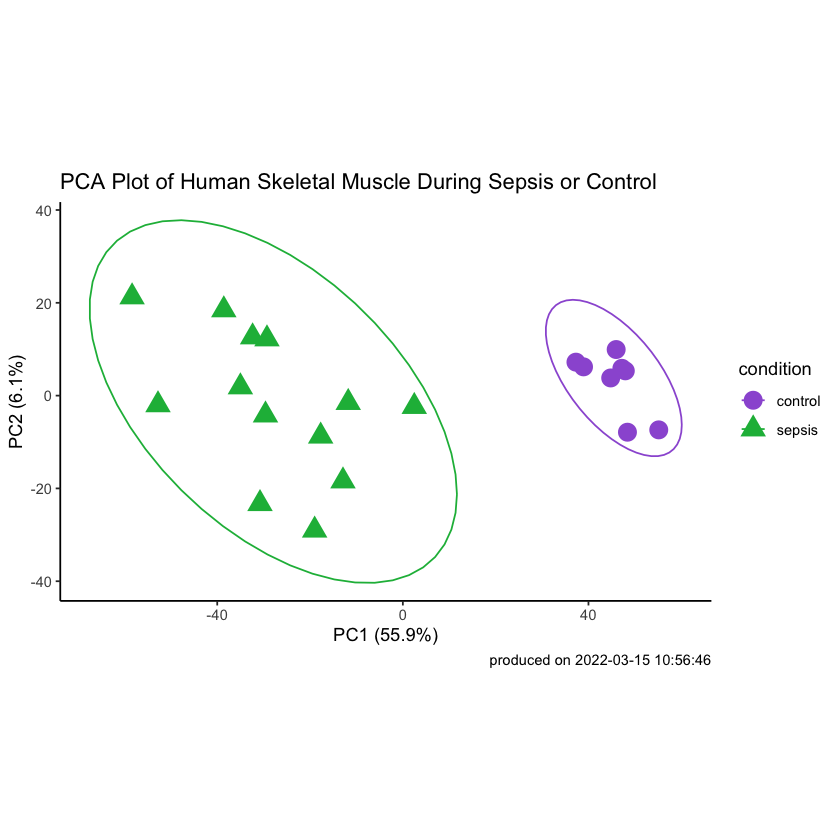

In [34]:
# Visualize your PCA result
#lets first plot any two PCs against each other
#We know how much each sample contributes to each PC (loadings), so let's plot
pca.res.df <- as_tibble(pca.res$x)
ggplot(pca.res.df) +
  aes(x=PC1, y=PC2, color=condition, shape=condition) +
  geom_point(size=5) +
  scale_color_manual(values = c("control" ="#9c5ed6",
                                "sepsis"="#17b847")) +
  # geom_label() +
  stat_ellipse() +
  xlab(paste0("PC1 (",pc.per[1],"%",")")) + 
  ylab(paste0("PC2 (",pc.per[2],"%",")")) +
  labs(title="PCA Plot of Human Skeletal Muscle During Sepsis or Control",
       caption=paste0("produced on ", Sys.time())) +
  coord_fixed() +
  theme_classic()
  
  ggsave("human_rna_sepsis_pca_AfterDataFilter.pdf", path = "/Users/brooksleitner/Desktop/Python/sepsismetabolism/figures/rna", device = "pdf", dpi = 300)